In [12]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

from rdkit.Chem import rdmolops

from rdkit.Chem import rdCoordGen

In [13]:
bb_df = pd.read_csv('bbs.csv')

bb_df

,id,Name,CAS,Abb,cids,smiles
0,0,Fmoc-beta-Ala-OH,35737-10-1,bAla,2724630,C1=CC=C2C(=C1)C(C3=CC=CC=C32)COC(=O)NCCC(=O)O
1,1,Fmoc-L-Pro-OH,71989-31-6,Pro,688135,C1C[C@H](N(C1)C(=O)OCC2C3=CC=CC=C3C4=CC=CC=C24...
2,2,Fmoc-L-Dab(Boc)-OH,125238-99-5,Dab,2756101,CC(C)(C)OC(=O)NCC[C@@H](C(=O)O)NC(=O)OCC1C2=CC...
3,3,Fmoc-L-Asp(OtBu)-OH,71989-14-5,Asp,2724635,CC(C)(C)OC(=O)C[C@@H](C(=O)O)NC(=O)OCC1C2=CC=C...
4,4,Fmoc-L-MeAla-OH,84000-07-7,NMeAla,688634,C[C@@H](C(=O)O)N(C)C(=O)OCC1C2=CC=CC=C2C3=CC=C...
5,5,Fmoc-L-Trp-OH,35737-15-6,Trp,978343,C1=CC=C2C(=C1)C(C3=CC=CC=C32)COC(=O)N[C@@H](CC...
6,6,Terephthalic acid,100-21-0,ac174,7489,C1=CC(=CC=C1C(=O)O)C(=O)O
7,7,Mono-Tert-Butyl Succinate,15026-17-2,ac255,4139107,CC(C)(C)OC(=O)CCC(=O)O
8,8,Acetic acid,64-19-7,ac47,176,CC(=O)O


In [21]:
bbdict = {}

for idx, aa in enumerate(bb_df['Name']):
    bbdict[aa] = bb_df['smiles'][idx]

bbdict['res2'] = 'SCCCNC(OCC1C(C=CC=C2)=C2C3=C1C=CC=C3)=O'
bbdict['mpa'] = 'O=C(O)CCS'
bbdict['linker1'] = 'O=C(CCl)CCl'

In [22]:
def build_peptide(sequence):

    print('this is the sequence: ' + str(sequence))

    sequence = sequence.split(' ')
    sequence.reverse()

    #fmoc coupling
    rxn = AllChem.ReactionFromSmarts('([#8]=[#6](-[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')

    reacts = (Chem.MolFromSmiles(bbdict[sequence[0]]), Chem.MolFromSmiles(bbdict[sequence[1]]))

    products = rxn.RunReactants(reacts)

    product = products[0][0]

    if len(sequence) == 2:
        return Chem.MolToSmiles(product)
    else:
        for aa in sequence[2:]:
            reacts = (product,Chem.MolFromSmiles(bbdict[aa]))
            products = rxn.RunReactants(reacts) # tuple

            product = products[0][0]


        #Remove protecting groups
            
        #remove nboc
        nboc = 'CC(C)(C)OC(NC)=O'
        if product.HasSubstructMatch(Chem.MolFromSmiles(nboc)):
            # print('nboc removal')
            # display(product)
            rxn = AllChem.ReactionFromSmarts('([#6]-[#6](-[#6])(-[#6])-[#8]-[#6](-[#7:1]-[#6:2])=[#8])>>[#7:1]-[#6:2]')
            reacts = (product,)
            products = rxn.RunReactants(reacts)
            product = products[0][0]

        mol = product

        #remove tbu
        tbu = 'COC(C)(C)C'

        pgs = [tbu]
        pgrepl = ['CO']

        for idx, pg in enumerate(pgs):
            mol = Chem.rdmolops.ReplaceSubstructs(mol, Chem.MolFromSmiles(pg), Chem.MolFromSmiles(pgrepl[idx]))
            mol = mol[0]

        #remove pbf, trt
        pbf = 'CC1(C)Cc2c(C)c(S(=O)=O)c(C)c(C)c2O1'
        trt = 'C(c1ccccc1)(c2ccccc2)c3ccccc3'

        pgs = [pbf, trt]

        for idx, pg in enumerate(pgs):
            mol = Chem.rdmolops.DeleteSubstructs(mol, Chem.MolFromSmiles(pg))
            # print(pg)
            # display(mol)

        smile = Chem.MolToSmiles(mol, kekuleSmiles = True)
        product = Chem.MolFromSmiles(smile)
        
        #fmoc removal if neccessary
        product = rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles('O=COCC1C2=C(C=CC=C2)C3=C1C=CC=C3'))

        display(product)

        return product

In [23]:
def disulfide_cyc(linear_peptide):
    
    oxrxn = AllChem.ReactionFromSmarts('([#16:1].[#16:2])>>[#16:1]-[#16:2]')
    reacts = (linear_peptide,)
    products = oxrxn.RunReactants(reacts) # tuple

    product = products[0][0]
    
    rdCoordGen.AddCoords(product) #makes mc look nicer

    display(product)

    return product

In [24]:
def linker_cyc(linear_peptide, linker):
    
    cycrxn = AllChem.ReactionFromSmarts('([#16:1]-[#6:2].[#16:3]-[#6:4]).([#6:5]-[#17].[#6:6]-[#17])>>([#6:2]-[#16:1]-[#6:5].[#6:4]-[#16:3]-[#6:6])')
    reacts = (linear_peptide, linker)
    products = cycrxn.RunReactants(reacts) # tuple

    product = products[0][0]
    
    rdCoordGen.AddCoords(product) #makes mc look nicer

    display(product)

    return product

In [53]:
sequences = ['mpa Asp Asp Asp res2']

this is the sequence: mpa Asp Asp Asp res2


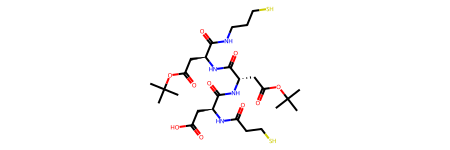

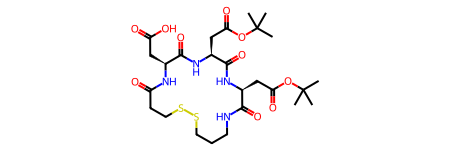

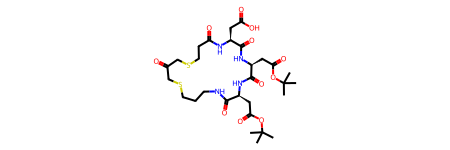

In [54]:
for sequence in sequences:
    linear_peptide = build_peptide(sequence)
    disulfide_cyc(linear_peptide)
    linker = Chem.MolFromSmiles(bbdict['linker1'])
    linker_cyc(linear_peptide, linker)

In [49]:
bbdict

{'bAla': 'C1=CC=C2C(=C1)C(C3=CC=CC=C32)COC(=O)NCCC(=O)O',
 'Pro': 'C1C[C@H](N(C1)C(=O)OCC2C3=CC=CC=C3C4=CC=CC=C24)C(=O)O',
 'Dab': 'CC(C)(C)OC(=O)NCC[C@@H](C(=O)O)NC(=O)OCC1C2=CC=CC=C2C3=CC=CC=C13',
 'Asp': 'CC(C)(C)OC(=O)C[C@@H](C(=O)O)NC(=O)OCC1C2=CC=CC=C2C3=CC=CC=C13',
 'NMeAla': 'C[C@@H](C(=O)O)N(C)C(=O)OCC1C2=CC=CC=C2C3=CC=CC=C13',
 'Trp': 'C1=CC=C2C(=C1)C(C3=CC=CC=C32)COC(=O)N[C@@H](CC4=CNC5=CC=CC=C54)C(=O)O',
 'ac174': 'C1=CC(=CC=C1C(=O)O)C(=O)O',
 'ac255': 'CC(C)(C)OC(=O)CCC(=O)O',
 'ac47': 'CC(=O)O',
 'res2': 'SCCCNC(OCC1C(C=CC=C2)=C2C3=C1C=CC=C3)=O',
 'mpa': 'O=C(O)CCS',
 'linker1': 'O=C(CCl)CCl'}